In [28]:
import pandas as pd
import numpy as np
import os

path = os.path.join("../../data", "integrated_data_20251023_190200.csv")

if os.path.exists(path):
    df = pd.read_csv(path)

    numeric_columns = [
        'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3',
        'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky'
    ]

    data = df[numeric_columns].values.astype(np.float32)

    print("Data shape:", df.shape)
else:
    print("File not found:", path)

print(df.head(20))

trainX = torch.tensor(
    data[:0:9],
    dtype = torch.float32
)
print(trainX.shape[0])

trainY = torch.tensor(
    data[:9:15],
    dtype = torch.float32
)
print(trainY.shape[0])


Data shape: (1000, 17)
                     timestamp  iteration  env0  raw0  env1  raw1  env2  raw2  \
0   2025-10-23T19:03:27.156296          0   860   776   263   194   558   560   
1   2025-10-23T19:03:27.310239          1   728   760   489   194   504   558   
2   2025-10-23T19:03:27.469278          2   855   752   378   190   423   550   
3   2025-10-23T19:03:27.604906          3   662   758   196   198   419   547   
4   2025-10-23T19:03:27.750387          4   908   759   389   201   420   490   
5   2025-10-23T19:03:27.894504          5   597   760   210   198   442   464   
6   2025-10-23T19:03:28.051522          6   643   760   331   192   389   442   
7   2025-10-23T19:03:28.214071          7   939   760   155   188   462   424   
8   2025-10-23T19:03:28.360182          8   584   760     6   188   582   415   
9   2025-10-23T19:03:28.503633          9  1014   766   168   184   403   408   
10  2025-10-23T19:03:28.652317         10   827   766   388   188   318   400   
11  2

In [26]:
print("Tobias er veldig kjekk")

Tobias er veldig kjekk


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

t = np.linspace(0, 100, 1000)
data = np.sin(t)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)\

seq_length = 10
X, y = create_sequences(data, seq_length)

trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)


In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

In [5]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
num_epochs = 100
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        

Epoch [10/100], Loss: 0.2866
Epoch [20/100], Loss: 0.0900
Epoch [30/100], Loss: 0.0379
Epoch [40/100], Loss: 0.0184
Epoch [50/100], Loss: 0.0027
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


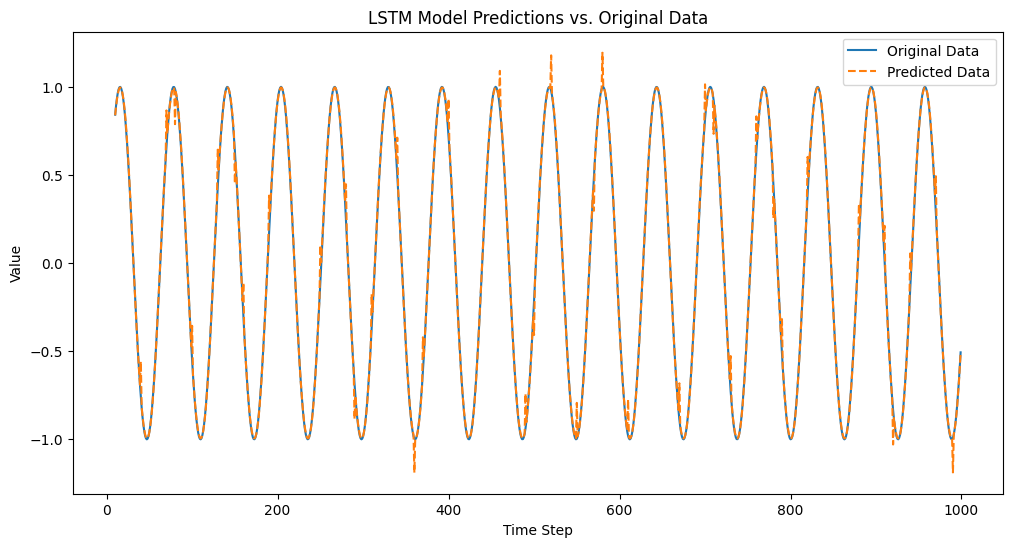

In [7]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = data[seq_length:]
time_steps = np.arange(seq_length, len(data))

predicted[::30] += 0.2
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()
